# Machine Learning Engineer Nanodegree

## Capstone Project

### Inspired by the [Animal Shelter Outcome](https://www.kaggle.com/c/shelter-animal-outcomes) competition in Kaggle

In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from time import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
# Force floating point division
from __future__ import division

In [3]:
# Read train data (to be used for both training and testing locally)
raw_train_data = pd.read_csv("data/train.csv")
print raw_train_data.head()

  AnimalID     Name             DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone  2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily  2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce  2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN  2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN  2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4      

In [4]:
# Read data from test csv file (to be used for Kaggle evaluation engine)
raw_kaggle_test_data = pd.read_csv("data/test.csv")
print raw_kaggle_test_data.head()

   ID      Name             DateTime AnimalType SexuponOutcome AgeuponOutcome  \
0   1    Summer  2015-10-12 12:15:00        Dog  Intact Female      10 months   
1   2  Cheyenne  2014-07-26 17:59:00        Dog  Spayed Female        2 years   
2   3       Gus  2016-01-13 12:20:00        Cat  Neutered Male         1 year   
3   4     Pongo  2013-12-28 18:12:00        Dog    Intact Male       4 months   
4   5   Skooter  2015-09-24 17:59:00        Dog  Neutered Male        2 years   

                            Breed        Color  
0          Labrador Retriever Mix    Red/White  
1  German Shepherd/Siberian Husky    Black/Tan  
2          Domestic Shorthair Mix  Brown Tabby  
3               Collie Smooth Mix     Tricolor  
4            Miniature Poodle Mix        White  


## Training Considerations

### Features/columns to be considered

- OutcomeType
- AnimalType
- SexuponOutcome
- AgeuponOutcome
- Breed 
- Color

### Features/columns to be ignored

- AnimalID: this is for internal use only.
- Name: this is probably not relevant to predict the animal's outcome.
- DateTime: this is only relevant for when the train data was captured, yet irrelevant for future predictions. Plus, it would be imposible to know when in the future the to-be-predicted outcome will take place.
- OutcomeSubtype: this is outside of the project scope.

## Data Cleanup

##### Remove ignored features/columns from both data sets

In [172]:
# Remove ignored features/columns
train_data = raw_train_data.drop(['AnimalID', 'Name', 'DateTime', 'OutcomeSubtype'], axis=1)
print train_data.head()

       OutcomeType AnimalType SexuponOutcome AgeuponOutcome  \
0  Return_to_owner        Dog  Neutered Male         1 year   
1       Euthanasia        Cat  Spayed Female         1 year   
2         Adoption        Dog  Neutered Male        2 years   
3         Transfer        Cat    Intact Male        3 weeks   
4         Transfer        Dog  Neutered Male        2 years   

                         Breed        Color  
0        Shetland Sheepdog Mix  Brown/White  
1       Domestic Shorthair Mix  Cream Tabby  
2                 Pit Bull Mix   Blue/White  
3       Domestic Shorthair Mix   Blue Cream  
4  Lhasa Apso/Miniature Poodle          Tan  


In [6]:
kaggle_test_data = raw_kaggle_test_data.drop(['Name', 'DateTime'], axis=1)
print kaggle_test_data.head()

   ID AnimalType SexuponOutcome AgeuponOutcome  \
0   1        Dog  Intact Female      10 months   
1   2        Dog  Spayed Female        2 years   
2   3        Cat  Neutered Male         1 year   
3   4        Dog    Intact Male       4 months   
4   5        Dog  Neutered Male        2 years   

                            Breed        Color  
0          Labrador Retriever Mix    Red/White  
1  German Shepherd/Siberian Husky    Black/Tan  
2          Domestic Shorthair Mix  Brown Tabby  
3               Collie Smooth Mix     Tricolor  
4            Miniature Poodle Mix        White  


## Data exploration

In [163]:
n_cols = len(train_data.columns)
n_rows = len(train_data)

print "Train dataset number of columns: {0}".format(n_cols)
print "Train dataset number of columns: {0}".format(n_rows)

Train dataset number of columns: 6
Train dataset number of columns: 26729


In [165]:
n_cols = len(kaggle_test_data.columns)
n_rows = len(kaggle_test_data)
A
print "Kaggle test dataset number of columns: {0}".format(n_cols)
print "Kaggle test dataset number of columns: {0}".format(n_rows)

Kaggle test dataset number of columns: 6
Kaggle test dataset number of columns: 11456


In [8]:
train_data.describe()

,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,26729,26728,26711,26729,26729
unique,5,2,5,44,1380,366
top,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,10769,15595,9779,3969,8810,2824


In [162]:
print len(raw_kaggle_test_data.values)
raw_kaggle_test_data.describe()

11456


,ID
count,11456.000000
mean,5728.500000
std,3307.206676
min,1.000000
25%,2864.750000
50%,5728.500000
75%,8592.250000
max,11456.000000


In [9]:
animaltype_groupby = train_data.groupby('AnimalType')
animaltype_groupby.describe()

AgeuponOutcome                   Breed        Color  \
AnimalType                                                              
Cat        count           11117                   11134        11134   
           unique             44                      60          146   
           top          2 months  Domestic Shorthair Mix  Brown Tabby   
           freq             2220                    8810         1635   
Dog        count           15594                   15595        15595   
           unique             43                    1320          262   
           top           2 years            Pit Bull Mix  Black/White   
           freq             2818                    1906         1730   

                  OutcomeType SexuponOutcome  
AnimalType                                    
Cat        count        11134          11134  
           unique           5              5  
           top       Transfer  Neutered Male  
           freq          5505           3065  
Dog        count        15595          15594  
           unique           5              5  
           top       Adoption  Neutered Male  
           freq          6497           6714

In [10]:
breed_groupby = train_data.groupby('Breed')
breed_groupby.describe()

AgeuponOutcome AnimalType  \
Breed                                                                       
Abyssinian Mix                           count               2          2   
                                         unique              2          1   
                                         top            1 year        Cat   
                                         freq                1          2   
Affenpinscher Mix                        count               6          6   
                                         unique              4          1   
                                         top            1 year        Dog   
                                         freq                2          6   
Afghan Hound Mix                         count               1          1   
                                         unique              1          1   
                                         top           2 years        Dog   
                                         freq                1          1   
Airedale Terrier                         count               1          1   
                                         unique              1          1   
                                         top           6 years        Dog   
                                         freq                1          1   
Airedale Terrier Mix                     count               5          5   
                                         unique              5          1   
                                         top           6 years        Dog   
                                         freq                1          5   
Airedale Terrier/Labrador Retriever      count               1          1   
                                         unique              1          1   
                                         top           4 years        Dog   
                                         freq                1          1   
Airedale Terrier/Miniature Schnauzer     count               1          1   
                                         unique              1          1   
                                         top           1 month        Dog   
                                         freq                1          1   
Akita                                    count               3          3   
                                         unique              2          1   
...                                                        ...        ...   
Yorkshire Terrier/Maltese                top           3 years        Dog   
                                         freq                2          4   
Yorkshire Terrier/Miniature Poodle       count              12         12   
                                         unique              8          1   
                                         top           4 years        Dog   
                                         freq                3         12   
Yorkshire Terrier/Miniature Schnauzer    count               8          8   
                                         unique              5          1   
                                         top           2 years        Dog   
                                         freq                3          8   
Yorkshire Terrier/Norfolk Terrier        count               1          1   
                                         unique              1          1   
                                         top           4 years        Dog   
                                         freq                1          1   
Yorkshire Terrier/Parson Russell Terrier count               1          1   
                                         unique              1          1   
                                         top           3 years        Dog   
                                         freq                1          1   
Yorkshire Terrier/Pomeranian             count               1          1   
                                         uni

In [149]:
color_groupby = train_data.groupby('Color')
color_groupby.describe()

AgeuponOutcome AnimalType                   Breed  \
Color                                                                           
Agouti               count               1          1                       1   
                     unique              1          1                       1   
                     top          9 months        Cat  Domestic Shorthair Mix   
                     freq                1          1                       1   
Agouti/Brown Tabby   count               1          1                       1   
                     unique              1          1                       1   
                     top          2 months        Cat  Domestic Shorthair Mix   
                     freq                1          1                       1   
Apricot              count              21         21                      21   
                     unique             12          1                       8   
                     top           5 years        Dog    Miniature Poodle Mix   
                     freq                4         21                      12   
Apricot/Brown        count               2          2                       2   
                     unique              2          1                       2   
                     top           3 years        Dog    Miniature Poodle Mix   
                     freq                1          2                       1   
Apricot/White        count               3          3                       3   
                     unique              2          1                       2   
                     top            1 year        Dog            Pit Bull Mix   
                     freq                2          3                       2   
Black                count            2288       2292                    2292   
                     unique             42          2                     187   
                     top          2 months        Cat  Domestic Shorthair Mix   
                     freq              343       1441                    1216   
Black Brindle        count              20         20                      20   
                     unique             12          1                      15   
                     top            1 year        Dog            Pit Bull Mix   
                     freq                4         20                       5   
Black Brindle/Black  count               1          1                       1   
                     unique              1          1                       1   
...                                    ...        ...                     ...   
Yellow               top           2 years        Dog  Labrador Retriever Mix   
                     freq               32        185                     112   
Yellow Brindle       count              12         12                      12   
                     unique              9          1                       9   
                     top            1 year        Dog           Catahoula Mix   
                     freq                3         12                       3   
Yellow Brindle/Blue  count               1          1                       1   
                     unique              1          1                       1   
                     top           3 years        Dog            Pit Bull Mix   
                     freq                1          1                       1   
Yellow Brindle/Tan   count               1          1                       1   
                     unique              1          1                       1   
                     top           4 years        Dog            Pit Bull Mix   
                     freq                1          1                       1   
Yellow Brindle/White count              17         17                      17   
                     unique              9          1                      11   
                     top            1 year        Dog      

In [11]:
ageuponoutcome_groupby = train_data.groupby('AgeuponOutcome')
ageuponoutcome_groupby.describe()

AnimalType                   Breed        Color  \
AgeuponOutcome                                                          
0 years        count          22                      22           22   
               unique          2                       4           13   
               top           Cat  Domestic Shorthair Mix        White   
               freq           15                      14            6   
1 day          count          66                      66           66   
               unique          2                       4           21   
               top           Cat  Domestic Shorthair Mix        Black   
               freq           54                      54           11   
1 month        count        1281                    1281         1281   
               unique          2                     118          106   
               top           Cat  Domestic Shorthair Mix  Black/White   
               freq          768                     587          153   
1 week         count         146                     146          146   
               unique          2                       9           28   
               top           Cat  Domestic Shorthair Mix  Brown Tabby   
               freq          119                     107           27   
1 weeks        count         171                     171          171   
               unique          2                      14           43   
               top           Cat  Domestic Shorthair Mix  Black/White   
               freq          142                     133           28   
1 year         count        3969                    3969         3969   
               unique          2                     515          190   
               top           Dog  Domestic Shorthair Mix  Black/White   
               freq         2750                     976          411   
10 months      count         457                     457          457   
               unique          2                     162           82   
               top           Dog  Domestic Shorthair Mix  Black/White   
               freq          350                      77           55   
10 years       count         446                     446          446   
               unique          2                     148           87   
...                          ...                     ...          ...   
6 months       top           Dog  Domestic Shorthair Mix  Black/White   
               freq          336                     200           81   
6 years        count         670                     670          670   
               unique          2                     196          113   
               top           Dog  Domestic Shorthair Mix  Black/White   
               freq          542                      87           61   
7 months       count         288                     288          288   
               unique          2                      97           68   
               top           Dog  Domestic Shorthair Mix  Black/White   
               freq          179                      87           28   
7 years        count         531                     531          531   
               unique          2                     176           96   
               top           Dog  Domestic Shorthair Mix  Black/White   
               freq          412                      75           46   
8 months       count         402                     402          402   
               unique          2                     122           76   
               top           Dog  Domestic Shorthair Mix  Black/White   
               freq          272                     116           60   
8 years        count         536                     536          536   
               unique          2                     157           89   
               top           Dog  Domestic Shorthair Mix  Black/White   
               freq          395                      96           51   
9 month

In [147]:
sexuponoutcome_groupby = train_data.groupby('SexuponOutcome')
sexuponoutcome_groupby.describe()

AgeuponOutcome AnimalType                   Breed  \
SexuponOutcome                                                            
Intact Female  count            3504       3511                    3511   
               unique             43          2                     280   
               top            1 year        Cat  Domestic Shorthair Mix   
               freq              506       2114                    1696   
Intact Male    count            3519       3525                    3525   
               unique             42          2                     342   
               top           1 month        Cat  Domestic Shorthair Mix   
               freq              451       1927                    1597   
Neutered Male  count            9779       9779                    9779   
               unique             30          2                     935   
               top           2 years        Dog  Domestic Shorthair Mix   
               freq             1551       6714                    2334   
Spayed Female  count            8819       8820                    8820   
               unique             31          2                     829   
               top            1 year        Dog  Domestic Shorthair Mix   
               freq             1404       5808                    2279   
Unknown        count            1089       1093                    1093   
               unique             36          2                      37   
               top           2 weeks        Cat  Domestic Shorthair Mix   
               freq              156       1016                     904   

                             Color OutcomeType  
SexuponOutcome                                  
Intact Female  count          3511        3511  
               unique          172           5  
               top     Black/White    Transfer  
               freq            325        2550  
Intact Male    count          3525        3525  
               unique          169           5  
               top           Black    Transfer  
               freq            368        2334  
Neutered Male  count          9779        9779  
               unique          245           5  
               top     Black/White    Adoption  
               freq           1089        5222  
Spayed Female  count          8820        8820  
               unique          261           5  
               top     Black/White    Adoption  
               freq            919        5186  
Unknown        count          1093        1093  
               unique           64           4  
               top           Black    Transfer  
               freq            201         955

##### NOTES

- AgeuponOutcome is recorded in days, weeks, months, or years. We'll need to normalize it. The same applies to other features.
- There seems to be a ton of unique breeds (1380) as compared to the "uniqueness" of other features. The previous table suggests a lot of them have 1 or 2 unique values only. This could be troublesome when wanting to obtain useful trends for predictions, since there may not be enough data for those breeds to extract useful information. We may want to "group" them in a higher level of categorization in order to extract more useful info. E.g., we could group all Yorkshire breeds into a single breed.  

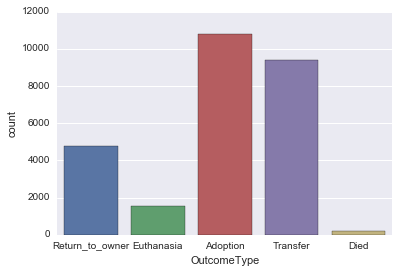

In [12]:
sns.countplot(train_data['OutcomeType'])

In [13]:
outcometype_groupby = train_data.groupby('OutcomeType')
outcometype_groupby.describe()

AgeuponOutcome AnimalType                   Breed  \
OutcomeType                                                                
Adoption        count           10769      10769                   10769   
                unique             28          2                     920   
                top          2 months        Dog  Domestic Shorthair Mix   
                freq             2636       6497                    3273   
Died            count             197        197                     197   
                unique             31          2                      35   
                top           1 month        Cat  Domestic Shorthair Mix   
                freq               48        147                     112   
Euthanasia      count            1553       1555                    1555   
                unique             39          2                     198   
                top           2 years        Dog  Domestic Shorthair Mix   
                freq              275        845                     535   
Return_to_owner count            4786       4786                    4786   
                unique             35          2                     639   
                top           2 years        Dog            Pit Bull Mix   
                freq              917       4286                     598   
Transfer        count            9406       9422                    9422   
                unique             41          2                     623   
                top            1 year        Cat  Domestic Shorthair Mix   
                freq             1417       5505                    4538   

                              Color SexuponOutcome  
OutcomeType                                         
Adoption        count         10769          10769  
                unique          260              4  
                top     Black/White  Neutered Male  
                freq           1183           5222  
Died            count           197            197  
                unique           48              5  
                top     Black/White    Intact Male  
                freq             27             79  
Euthanasia      count          1555           1555  
                unique          137              5  
                top     Black/White    Intact Male  
                freq            160            477  
Return_to_owner count          4786           4785  
                unique          212              5  
                top     Black/White  Neutered Male  
                freq            474           2247  
Transfer        count          9422           9422  
                unique          241              5  
                top     Black/White  Intact Female  
                freq            980           2550

In [14]:
train_data["OutcomeType"].value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [150]:
train_data["AnimalType"].value_counts()

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64

In [154]:
print "Dogs: {}%".format(15595*100/train_data["AnimalType"].count())
print "Cats: {}%".format(11134*100/train_data["AnimalType"].count())

Dogs: 58.344868869%
Cats: 41.655131131%


In [157]:
print "Euthanasia: {}%".format(1555*100/train_data["AnimalType"].count())
print "Died: {}%".format(197*100/train_data["AnimalType"].count())
print "Euthanasia + Died: {}% or {}".format((1555+197)*100/train_data["AnimalType"].count(), 1555+197)

Euthanasia: 5.81765124023%
Died: 0.737027198923%
Euthanasia + Died: 6.55467843915% or 1752


##### Graph Age/Outcome Relationships

In [173]:
# Graph Age/Outcome relationships
train_data_clone = train_data.copy()
train_data_clone['AgeuponOutcome'] = train_data_clone['AgeuponOutcome'].map(convert_to_days)


##### Bar plot: AgeuponOutcome counts of Died

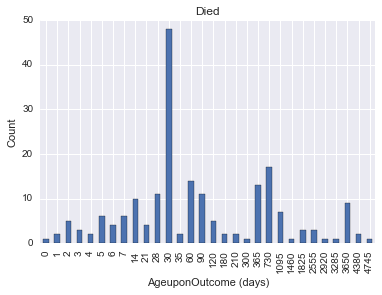

In [194]:
graph = train_data_clone.groupby(['OutcomeType', 'AgeuponOutcome']).size().loc['Died'].plot.bar()
graph.set_xlabel("AgeuponOutcome (days)")
graph.set_ylabel("Count")
graph.set_title("Died")

##### Bar plot: AgeuponOutcome counts of Euthanasia

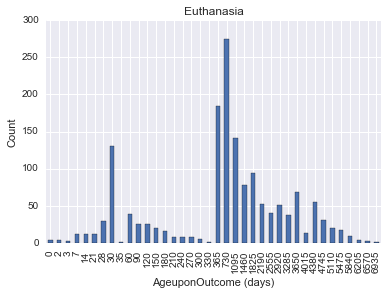

In [195]:
graph = train_data_clone.groupby(['OutcomeType', 'AgeuponOutcome']).size().loc['Euthanasia'].plot.bar(y='count')
graph.set_xlabel("AgeuponOutcome (days)")
graph.set_ylabel("Count")
graph.set_title("Euthanasia")

## Data Preparation

##### Extract feature/target cols

In [15]:
# Extract feature columns
X_all = train_data.drop(['OutcomeType'], axis=1)
feature_cols = list(X_all.columns)

# Extract target column 'OutcomeType'
y_all = train_data['OutcomeType']

print "X_all head:"
print X_all.head()

print "\ny_all head:"
print y_all.head()

X_all head:
  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4          Tan  

y_all head:
0    Return_to_owner
1         Euthanasia
2           Adoption
3           Transfer
4           Transfer
Name: OutcomeType, dtype: object


##### Preprocess columns to make normalize them

In [28]:
# Set up label encoders

# AnimalType
animal_type_label_encoder = preprocessing.LabelEncoder()
animal_type_label_encoder.fit(np.append(train_data["AnimalType"].values, kaggle_test_data["AnimalType"].values))

# SexuponOutcome
sex_upon_outcome_label_encoder = preprocessing.LabelEncoder()
sex_upon_outcome_label_encoder.fit(np.append(train_data["SexuponOutcome"].values, kaggle_test_data["SexuponOutcome"].values))

# Breed
breed_label_encoder = preprocessing.LabelEncoder()
breed_label_encoder.fit(np.append(train_data["Breed"].values, kaggle_test_data["Breed"].values))

# Color
color_label_encoder = preprocessing.LabelEncoder()
color_label_encoder.fit(np.append(train_data["Color"].values, kaggle_test_data["Color"].values))

# Outcome Type
outcome_type_label_encoder = preprocessing.LabelEncoder()
outcome_type_label_encoder.fit(train_data["OutcomeType"].values)

LabelEncoder()

In [198]:
print len(animal_type_label_encoder.classes_)
print len(sex_upon_outcome_label_encoder.classes_)
print len(breed_label_encoder.classes_)
print len(color_label_encoder.classes_)
print len(outcome_type_label_encoder.classes_)

2
6
1678
411
5


In [17]:
def normalize_data(D):
    ''' 
    Normalizes all data columns by:
    - Converting AgeuponOutcome to days
    - Using label encoding for the rest of the features. 
    '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = D.index)

    # Process each feature
    for col, col_data in D.iteritems():
        
        # If column is AgeuponOutcome, convert to days (int)
        if col == 'AgeuponOutcome':
            col_data = col_data.map(convert_to_days)
        # else use label encoders    
        elif col == 'AnimalType':
            col_data = col_data.map(lambda x: animal_type_label_encoder.transform([x])[0])
        elif col == 'SexuponOutcome':
            # Workaorund for nan issue with sex_upon_outcome_label_encoder
            col_data = col_data.map(lambda x: sex_upon_outcome_label_encoder.transform([x])[0] if x in sex_upon_outcome_label_encoder.classes_ else 0)
        elif col == 'Breed':
            col_data = col_data.map(lambda x: breed_label_encoder.transform([x])[0])
        elif col == 'Color':
            col_data = col_data.map(lambda x: color_label_encoder.transform([x])[0])

        # Collect the revised columns
        output = output.join(col_data)
    
    return output

def convert_to_days(s):
    '''
    Returns the day number (int) equivalent of parameter s
    '''
 
    if type(s) == float:
        return 0
    
    (quantity, period) = s.split(" ")
    quantity = int(quantity)
    
    if "week" in period:
        quantity = quantity * 7
    elif "month" in period:
        quantity = quantity * 30
    elif "year" in period:
        quantity = quantity * 365
    
    return quantity
        

In [18]:
X_all_normalized = normalize_data(X_all)

In [19]:
print X_all_normalized.head()

   AnimalType  SexuponOutcome  AgeuponOutcome  Breed  Color
0           1               3             365   1482    146
1           0               4             365    775    184
2           1               3             730   1293     97
3           0               2              21    775     47
4           1               3             730   1101    311


##### Prepare test data for Kaggle submission

Since Kaggle's evaluation engine uses a different data set (than the one used for training), we need to make sure the columns between the train set and the Kaggle test set match. That way we can use the same "trained" classifier for both local-testing and Kaggle-testing predictions.

In [55]:
kaggle_test_data_ids = kaggle_test_data['ID']
kaggle_test_data_values = kaggle_test_data[['AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']]

In [56]:
kaggle_test_data_normalized = normalize_data(kaggle_test_data_values)

In [57]:
print kaggle_test_data_normalized.head()

   AnimalType  SexuponOutcome  AgeuponOutcome  Breed  Color
0           1               1             300   1023    283
1           1               4             730    875     40
2           0               3             365    775    117
3           1               2             120    658    346
4           1               3             730   1165    359


In [84]:
def create_csv_for_kaggle_submission(clf, filepath):
    '''
    Saves a csv file ready for Kaggle submission, under the filepath specified
    '''
    
    # Make predictions based on Kaggle test data set
    kaggle_predictions = clf.predict_proba(kaggle_test_data_normalized)
    
    # Add animal IDs
    kaggle_predictions_with_id = np.copy(kaggle_predictions)
    kaggle_predictions_with_id = np.insert(kaggle_predictions_with_id, 0, 0, axis=1)
    for i, pred in enumerate(kaggle_predictions_with_id):
        pred[0] = np.int64(kaggle_test_data_ids[i])
        kaggle_predictions_with_id[i] = pred

    # Prepend header
    header = np.insert(np.array(clf.classes_), 0, 'ID')
    kaggle_predictions_to_csv = np.vstack((header, kaggle_predictions_with_id))

    # Convert first column to int (since it's an ID)
    kaggle_predictions_to_csv.astype(object)
    for i, pred in enumerate(kaggle_predictions_to_csv):
        if i != 0:
            animalId = int(pred[0])
            pred[0] = animalId
            kaggle_predictions_to_csv[i] = pred
    
    # Save csv
    np.savetxt(filepath, kaggle_predictions_to_csv, delimiter=",", fmt="%s")

##### Split training/test data

We'll be doing local testing of our models before submitting them to Kaggle's evaluation engine for the final scores. To do this, we'll split the whole data set available in the `train.csv` file into training and testing data.

In [59]:
# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all_normalized, y_all, \
    test_size = .2, random_state = 5)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

# Show first rows of train/test sets
print "\nX_train.head()"
print X_train.head()

print "\nX_test.head()"
print X_test.head()

print "\ny_train.head()"
print y_train.head()

print "\ny_test.head()"
print y_test.head()

Training set has 21383 samples.
Testing set has 5346 samples.

X_train.head()
       AnimalType  SexuponOutcome  AgeuponOutcome  Breed  Color
5909            1               3             730    574    370
3806            1               3             365    307    370
3571            1               3            1460    840    128
18840           0               4             365   1515    241
15017           0               5               7    775     70

X_test.head()
       AnimalType  SexuponOutcome  AgeuponOutcome  Breed  Color
9719            1               3             365   1112    359
23467           1               4             730   1661      6
22442           1               4            3650   1293     99
7710            1               3            4745    760    361
541             1               4             120    605    257

y_train.head()
5909            Adoption
3806            Adoption
3571            Transfer
18840    Return_to_owner
15017           Transfe

## Model Trainings and Evaluations

### Decision Tree

In [85]:
# Train
clf_dt = DecisionTreeClassifier(random_state=3)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=3, splitter='best')

In [86]:
# Predict
y_pred_dt = clf_dt.predict(X_test)
y_pred_proba_dt = clf_dt.predict_proba(X_test)

In [87]:
print y_pred_dt
print clf_dt.classes_
print y_pred_proba_dt

['Transfer' 'Adoption' 'Adoption' ..., 'Transfer' 'Transfer' 'Adoption']
['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
[[ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]]


In [28]:
# Evaluate locally
print "F1 score: {0}".format(f1_score(y_test, y_pred_dt, average='macro'))
print "Log loss score: {0}".format(log_loss(y_test, y_pred_proba_dt))

F1 score: 0.381975551094
Log loss score: 11.5973074812


In [29]:
# Evaluate in Kaggle engine
create_csv_for_kaggle_submission(clf_dt, 'kaggle/dt_prediction_1.csv')

### SVM (with probabilistic classification)

In [30]:
# Train
clf_svc = SVC(random_state=3, probability=True)
clf_svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=3, shrinking=True, tol=0.001,
  verbose=False)

In [31]:
# Predict
y_pred_svc = clf_svc.predict(X_test)
y_pred_proba_svc = clf_svc.predict_proba(X_test)

In [32]:
print y_pred_svc
print clf_svc.classes_
print y_pred_proba_svc

['Adoption' 'Adoption' 'Adoption' ..., 'Transfer' 'Adoption' 'Adoption']
['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
[[ 0.46946364  0.00626929  0.04125591  0.11794097  0.3650702 ]
 [ 0.59808627  0.00652911  0.04978646  0.1536531   0.19194506]
 [ 0.40909539  0.00692019  0.06006413  0.20255296  0.32136732]
 ..., 
 [ 0.10278396  0.0091901   0.11545898  0.09630055  0.67626641]
 [ 0.40893879  0.00691997  0.0600595   0.20249246  0.32158927]
 [ 0.40909548  0.00692019  0.06006413  0.20255294  0.32136726]]


In [33]:
# Evaluate locally
print "F1 score: {0}".format(f1_score(y_test, y_pred_svc, average='macro'))
print "Log loss score: {0}".format(log_loss(y_test, y_pred_proba_svc))

F1 score: 0.295550271657
Log loss score: 1.10737108308


/Users/Rafael/Library/Miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
# Evaluate in Kaggle engine
create_csv_for_kaggle_submission(clf_svc, 'kaggle/svc_prediction_1.csv')

## XGBoost

In [64]:
# Train
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='multi:softprob', seed=0, silent=True,
       subsample=1)

In [65]:
# Predict
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)

In [67]:
print y_pred_xgb
print y_pred_proba_xgb

['Adoption' 'Adoption' 'Return_to_owner' ..., 'Transfer' 'Adoption'
 'Adoption']
[[ 0.54205519  0.00260836  0.01753607  0.24233027  0.19547006]
 [ 0.47273889  0.00297968  0.03300767  0.30149472  0.189779  ]
 [ 0.28652975  0.00750766  0.1343701   0.43091229  0.14068016]
 ..., 
 [ 0.00165161  0.01733342  0.02138626  0.00251821  0.95711046]
 [ 0.54346246  0.00270708  0.02063066  0.2080346   0.22516517]
 [ 0.73472923  0.00183548  0.00664239  0.07888239  0.17791051]]


In [68]:
# Evaluate locally
print "F1 score: {0}".format(f1_score(y_test, y_pred_xgb, average='macro'))
print "Log loss score: {0}".format(log_loss(y_test, y_pred_proba_xgb))

F1 score: 0.391109066138
Log loss score: 0.89408148122


/Users/Rafael/Library/Miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'weighted']


In [88]:
# Hack to provide classes via classifier
clf_xgb.classes_ = clf_dt.classes_

In [89]:
# Evaluate in Kaggle engine
create_csv_for_kaggle_submission(clf_xgb, 'kaggle/xgb_prediction_1.csv')

## Model Tuning

Let's work with XGBoost since it's given us the best results out-of-the-box, so it looks like the most promising of the models tried.

In [144]:
def tune_xgb(max_depth=3,
            learning_rate=0.1,
            min_child_weight=1,
            gamma=0,
            subsample=1,
            colsample_bytree=1,
            nthread=-1):
    '''
    Helper to train XGB classifier with provided params, and evaluate it
    with F1 score, Log Loss, and Kaggle's evaluation engine
    '''
    
    clf = xgb.XGBClassifier(max_depth=max_depth,
                           learning_rate=learning_rate,
                           min_child_weight=min_child_weight,
                           gamma=gamma,
                           subsample=subsample,
                           colsample_bytree=colsample_bytree,
                           nthread=nthread,
                           seed=3)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    
    print "F1 score: {}".format(f1_score(y_test, pred, average='macro'))
    print "Log loss score: {}".format(log_loss(y_test, pred_proba))
    
    # Hack to provide classes via classifier
    clf.classes_ = clf_dt.classes_
    create_csv_for_kaggle_submission(clf, 'kaggle/xgb_prediction_tuned')

##### Iterate over different params values and evaluate

In [103]:
tune_xgb(learning_rate=0.1,
         max_depth=5, 
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.389942969858
Log loss score: 0.887322965214


In [104]:
tune_xgb(learning_rate=0.1,
         max_depth=8, 
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.390399151584
Log loss score: 0.897113135346


In [109]:
tune_xgb(learning_rate=0.1,
         max_depth=5, 
         min_child_weight=10,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.38799251646
Log loss score: 0.888368358771


In [111]:
tune_xgb(learning_rate=0.1,
         max_depth=6, 
         min_child_weight=10,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.389099781841
Log loss score: 0.889976356804


In [117]:
tune_xgb(learning_rate=0.1,
         max_depth=6, 
         min_child_weight=12,
         gamma=0.1,
         subsample=0.8,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.386853861841
Log loss score: 0.88993136415


In [126]:
tune_xgb(learning_rate=0.1,
         max_depth=5, 
         min_child_weight=1,
         gamma=0,
         subsample=0.75,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.386109072909
Log loss score: 0.886623161465


In [127]:
tune_xgb(learning_rate=0.1,
         max_depth=5, 
         min_child_weight=1,
         gamma=0,
         subsample=0.9,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.390068868867
Log loss score: 0.886562164915


In [128]:
tune_xgb(learning_rate=0.1,
         max_depth=5, 
         min_child_weight=1,
         gamma=0,
         subsample=1.0,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.389613824045
Log loss score: 0.886711304789


In [129]:
tune_xgb(learning_rate=0.1,
         max_depth=5, 
         min_child_weight=1,
         gamma=0,
         subsample=0.95,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.3866113808
Log loss score: 0.887158694553


In [146]:
tune_xgb(learning_rate=0.1,
         max_depth=5, 
         min_child_weight=1,
         gamma=0,
         subsample=0.905,
         colsample_bytree=0.8,
         nthread=4)

F1 score: 0.38867136256
Log loss score: 0.886223103423
